In [99]:
# Import Packages
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, clone_model
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout, LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Dataset loading
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

In [2]:
# Load Data
heart_disease = fetch_ucirepo(id=45)
X_df = heart_disease.data.features.dropna()
y_df = heart_disease.data.targets.loc[X_df.index]
y_df = (y_df > 0).astype(int)
X_arr = X_df.values.astype(np.float32)
y_arr = y_df.values.ravel().astype(np.int32)

In [32]:
# Define Baseline DNN Function
def build_model(input_dim, hidden_units):
    inputs = Input(shape=(input_dim,))
    x = Dense(hidden_units)(inputs)
    x = LeakyReLU(negative_slope=0.01)(x)
    x = Dense(round(hidden_units / 2))(x)
    x = LeakyReLU(negative_slope=0.01)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [69]:
# Baseline DNN
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
accs, precs, recs, f1s = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_arr, y_arr), 1):
    print(f"\n--- Fold {fold} ---")

    X_tr, X_te = X_arr[train_idx], X_arr[test_idx]
    y_tr, y_te = y_arr[train_idx], y_arr[test_idx]

    # Standard scaling
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_te_scaled = scaler.transform(X_te)

    # PCA
    pca = PCA(n_components=0.95)
    X_tr_pca = pca.fit_transform(X_tr_scaled)
    X_te_pca = pca.transform(X_te_scaled)

    # Class weights
    cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)
    cw_dict = dict(enumerate(cw))

    # Model build + train
    model = build_model(input_dim=X_tr_pca.shape[1], hidden_units=200)
    model.fit(
        X_tr_pca, y_tr,
        validation_data=(X_te_pca, y_te),
        epochs=1500,
        batch_size=32,
        class_weight=cw_dict,
        callbacks=[reduce_lr, es],
        verbose=0
    )

    # Evaluation
    y_pred = (model.predict(X_te_pca, verbose=0) > 0.5).astype(int).ravel()
    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, zero_division=0)
    rec = recall_score(y_te, y_pred, zero_division=0)
    f1 = f1_score(y_te, y_pred, zero_division=0)
    print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")

    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)

# Summary
print("\n--- 3-Fold CV Summary ---")
print(f"Accuracy : {np.mean(accs):.3f}")
print(f"Precision: {np.mean(precs):.3f}")
print(f"Recall   : {np.mean(recs):.3f}")
print(f"F1 Score : {np.mean(f1s):.3f}")


--- Fold 1 ---
Accuracy: 0.859, Precision: 0.830, Recall: 0.867, F1: 0.848

--- Fold 2 ---
Accuracy: 0.788, Precision: 0.805, Recall: 0.717, F1: 0.759

--- Fold 3 ---
Accuracy: 0.838, Precision: 0.875, Recall: 0.761, F1: 0.814

--- 3-Fold CV Summary ---
Accuracy : 0.828
Precision: 0.837
Recall   : 0.782
F1 Score : 0.807


In [88]:
# Define SCANN Functions

def apply_masks_to_model(model, masks):
    mask_idx = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            w, b = layer.get_weights()
            mask = masks[mask_idx]
            if w.shape != mask.shape:
                raise ValueError(f"Shape mismatch: weight {w.shape} vs mask {mask.shape}")
            w = w * mask.numpy()  # still safe and simple for clarity, avoids graph tracing
            layer.set_weights([w, b])
            mask_idx += 1

def initialize_masks(model):
    masks = []
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            shape = layer.kernel.shape
            mask = tf.Variable(tf.ones(shape, dtype=tf.float32), trainable=False)
            masks.append(mask)
    return masks

def grow_connections(model, masks, growth_frac, Xb, yb):
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    with tf.GradientTape() as tape:
        preds = model(Xb, training=True)
        loss = loss_fn(yb, preds)
    grads = tape.gradient(loss, model.trainable_weights)

    for idx in range(0, len(model.trainable_weights), 2):  # skip biases
        w = model.trainable_weights[idx]
        gw = grads[idx]

        W_np = w.numpy()
        G_np = gw.numpy()
        C_np = masks[idx // 2].numpy()

        dormant = (C_np == 0)
        grad_magnitude = np.abs(G_np) * dormant
        num_to_grow = int(np.ceil(growth_frac * np.sum(dormant)))

        if num_to_grow == 0:
            continue

        flat_idx = np.argpartition(grad_magnitude.flatten(), -num_to_grow)[-num_to_grow:]
        row_idx, col_idx = np.unravel_index(flat_idx, grad_magnitude.shape)

        for r, c in zip(row_idx, col_idx):
            W_np[r, c] = np.random.normal(scale=0.01)
            C_np[r, c] = 1

        w.assign(W_np)
        masks[idx // 2].assign(C_np)

def prune_connections(model, masks, prune_frac, Xb, yb):
    loss_fn = tf.keras.losses.BinaryCrossentropy()

    with tf.GradientTape() as tape:
        preds = model(Xb, training=True)
        loss = loss_fn(yb, preds)

    grads = tape.gradient(loss, model.trainable_weights)

    for idx in range(0, len(model.trainable_weights), 2):  # skip biases
        w_tensor = model.trainable_weights[idx]
        g_tensor = grads[idx]

        W = w_tensor.numpy()
        G = g_tensor.numpy()
        mask = masks[idx // 2].numpy()

        grad_magnitude = np.abs(G)
        num_to_prune = int(np.ceil(prune_frac * grad_magnitude.size))
        if num_to_prune == 0:
            continue

        threshold = np.partition(grad_magnitude.flatten(), num_to_prune)[num_to_prune]
        prune_mask = grad_magnitude <= threshold

        W[prune_mask] = 0
        mask[prune_mask] = 0

        w_tensor.assign(W)
        masks[idx // 2].assign(mask)

def grow_model(model, masks, new_units, noise_scale=0.1):
    input_dim = model.input_shape[-1]
    dense_layers = [layer for layer in model.layers if isinstance(layer, Dense)]

    first_dense = dense_layers[0]
    penultimate_dense = dense_layers[-2]
    output_dense = dense_layers[-1]

    w0, b0 = first_dense.get_weights()
    wp, bp = penultimate_dense.get_weights()
    w1, b1 = output_dense.get_weights()

    old_units = w0.shape[1]
    total_units = old_units + new_units

    new_model = build_model(input_dim, total_units)
    new_dense_layers = [layer for layer in new_model.layers if isinstance(layer, Dense)]
    new_first_dense = new_dense_layers[0]
    new_penultimate_dense = new_dense_layers[-2]
    new_output_dense = new_dense_layers[-1]

    # First Dense Layer (input to hidden)
    W = np.random.normal(scale=noise_scale, size=(input_dim, total_units))
    B = np.random.normal(scale=noise_scale, size=(total_units,))
    W[:, :old_units] = w0
    B[:old_units] = b0
    new_first_dense.set_weights([W, B])

    # Penultimate Dense Layer (hidden to mid)
    hidden_mid_units = round(total_units / 2)
    Wp = np.random.normal(scale=noise_scale, size=(total_units, hidden_mid_units))
    Bp = np.random.normal(scale=noise_scale, size=(hidden_mid_units,))
    Wp[:wp.shape[0], :wp.shape[1]] = wp
    Bp[:bp.shape[0]] = bp
    new_penultimate_dense.set_weights([Wp, Bp])

    # Output layer
    if w1.ndim == 1:
        w1 = w1[:, np.newaxis]
    output_units = w1.shape[1]
    W1 = np.random.normal(scale=noise_scale, size=(hidden_mid_units, output_units))
    W1[:w1.shape[0], :w1.shape[1]] = w1
    new_output_dense.set_weights([W1, b1])

    # Update masks using tf.Variable to allow assignment later
    new_masks = []

    # First layer mask
    old_mask0 = masks[0].numpy()
    new_mask0 = np.zeros((input_dim, total_units), dtype=np.float32)
    new_mask0[:, :old_units] = old_mask0
    new_masks.append(tf.Variable(new_mask0, trainable=False))

    # Penultimate layer mask
    old_maskp = masks[1].numpy()
    new_maskp = np.zeros((total_units, hidden_mid_units), dtype=np.float32)
    new_maskp[:wp.shape[0], :wp.shape[1]] = old_maskp
    new_masks.append(tf.Variable(new_maskp, trainable=False))

    # Output layer mask
    old_mask1 = masks[2].numpy()
    new_mask1 = np.zeros((hidden_mid_units, output_units), dtype=np.float32)
    new_mask1[:w1.shape[0], :w1.shape[1]] = old_mask1
    new_masks.append(tf.Variable(new_mask1, trainable=False))

    return new_model, new_masks

In [89]:
# SCANN Scheme A
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=0)
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Cross-validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
a_accs, a_precs, a_recs, a_f1s = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_arr, y_arr), start=1):
          print(f"\n--- SCANN Scheme A Fold {fold} ---")
          x_train, X_te = X_arr[train_idx], X_arr[test_idx]
          y_tr, y_te = y_arr[train_idx], y_arr[test_idx]

          scaler = StandardScaler().fit(x_train)
          x_train_scaled = scaler.transform(x_train)
          X_te_scaled = scaler.transform(X_te)
          pca = PCA(n_components=0.95).fit(x_train_scaled)
          x_train_pca = pca.transform(x_train_scaled)
          X_te_pca = pca.transform(X_te_scaled)

          Xb = tf.convert_to_tensor(x_train_pca[:256], dtype=tf.float32)
          yb = tf.convert_to_tensor(y_tr[:256], dtype=tf.float32)

          cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)
          cw_dict = dict(enumerate(cw))

          model = build_model(input_dim=x_train_pca.shape[1], hidden_units=100)
          masks = initialize_masks(model)
          apply_masks_to_model(model, masks)

          model.fit(x_train_pca, y_tr, validation_data=(X_te_pca, y_te),
          epochs=100, batch_size=32, class_weight=cw_dict,
          callbacks=[reduce_lr, es], verbose=0)

          best_model = clone_model(model)
          best_model.set_weights(model.get_weights())
          best_val = model.evaluate(X_te_pca, y_te, verbose=0)[1]

          for cycle in range(10):

              print(f"-- Cycle {cycle+1} --")
              grow_connections(model, masks, growth_frac=0.8, Xb=Xb, yb=yb)
              apply_masks_to_model(model, masks)
              model.fit(x_train_pca, y_tr, validation_data=(X_te_pca, y_te),
              epochs=20, batch_size=32, class_weight=cw_dict,
              callbacks=[reduce_lr, es], verbose=0)

              model, masks = grow_model(model, masks, new_units=8)
              apply_masks_to_model(model, masks)
              model.fit(x_train_pca, y_tr, validation_data=(X_te_pca, y_te),
              epochs=20, batch_size=32, class_weight=cw_dict,
              callbacks=[reduce_lr, es], verbose=0)

              prune_connections(model, masks, prune_frac=0.3, Xb=Xb, yb=yb)
              apply_masks_to_model(model, masks)
              model.fit(x_train_pca, y_tr, validation_data=(X_te_pca, y_te),
              epochs=20, batch_size=32, class_weight=cw_dict,
              callbacks=[reduce_lr, es], verbose=0)

              val_acc = model.evaluate(X_te_pca, y_te, verbose=0)[1]
              if val_acc > best_val:
                  best_val = val_acc
                  best_model = clone_model(model)
                  best_model.set_weights(model.get_weights())

          y_pred = (best_model.predict(X_te_pca, verbose=0) > 0.5).astype(int).ravel()
          a = accuracy_score(y_te, y_pred)
          p = precision_score(y_te, y_pred, zero_division=0)
          r = recall_score(y_te, y_pred, zero_division=0)
          f1 = f1_score(y_te, y_pred, zero_division=0)
          print(f"Accuracy: {a:.3f}, Precision: {p:.3f}, Recall: {r:.3f}, F1: {f1:.3f}")

          a_accs.append(a); a_precs.append(p); a_recs.append(r); a_f1s.append(f1)

print("\n--- SCANN Scheme A Cross-Validation Summary ---")
print(f"Accuracy : {np.mean(a_accs):.3f}")
print(f"Precision: {np.mean(a_precs):.3f}")
print(f"Recall   : {np.mean(a_recs):.3f}")
print(f"F1 Score : {np.mean(a_f1s):.3f}")


--- SCANN Scheme A Fold 1 ---
-- Cycle 1 --
-- Cycle 2 --
-- Cycle 3 --
-- Cycle 4 --
-- Cycle 5 --
-- Cycle 6 --
-- Cycle 7 --
-- Cycle 8 --
-- Cycle 9 --
-- Cycle 10 --
Accuracy: 0.869, Precision: 0.864, Recall: 0.844, F1: 0.854

--- SCANN Scheme A Fold 2 ---
-- Cycle 1 --
-- Cycle 2 --
-- Cycle 3 --
-- Cycle 4 --
-- Cycle 5 --
-- Cycle 6 --
-- Cycle 7 --
-- Cycle 8 --
-- Cycle 9 --
-- Cycle 10 --
Accuracy: 0.818, Precision: 0.833, Recall: 0.761, F1: 0.795

--- SCANN Scheme A Fold 3 ---
-- Cycle 1 --
-- Cycle 2 --
-- Cycle 3 --
-- Cycle 4 --
-- Cycle 5 --
-- Cycle 6 --
-- Cycle 7 --
-- Cycle 8 --
-- Cycle 9 --
-- Cycle 10 --
Accuracy: 0.838, Precision: 0.857, Recall: 0.783, F1: 0.818

--- SCANN Scheme A Cross-Validation Summary ---
Accuracy : 0.842
Precision: 0.851
Recall   : 0.796
F1 Score : 0.823


In [94]:
# SCANN Scheme B
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=0)
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

b_accs, b_precs, b_recs, b_f1s = [], [], [], []
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(skf.split(X_arr, y_arr), 1):
    print(f"\n--- SCANN Scheme B Fold {fold} ---")

    x_train, X_te = X_arr[train_idx], X_arr[test_idx]
    y_tr, y_te = y_arr[train_idx], y_arr[test_idx]

    scaler = StandardScaler().fit(x_train)
    x_train_s = scaler.transform(x_train)
    X_te_s = scaler.transform(X_te)
    pca = PCA(0.95).fit(x_train_s)
    x_train_pca = pca.transform(x_train_s)
    X_te_pca = pca.transform(X_te_s)

    Xb = tf.convert_to_tensor(x_train_pca[:256], dtype=tf.float32)
    yb = tf.convert_to_tensor(y_tr[:256], dtype=tf.float32)

    cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)
    cw_dict = dict(enumerate(cw))

    model = build_model(input_dim=x_train_pca.shape[1], hidden_units=300)
    masks = initialize_masks(model)
    apply_masks_to_model(model, masks)
    model.fit(x_train_pca, y_tr, validation_data=(X_te_pca, y_te),
              epochs=100, batch_size=32, class_weight=cw_dict,
              callbacks=[reduce_lr, es], verbose=0)

    best_model = clone_model(model)
    best_model.set_weights(model.get_weights())
    best_acc = model.evaluate(x_train_pca, y_tr, verbose=0)[1]

    for cycle in range(10):
        print(f"-- Cycle {cycle + 1} --")

        # Connection pruning
        prune_connections(model, masks, prune_frac=0.95, Xb=Xb, yb=yb)
        apply_masks_to_model(model, masks)

        # Fine-tune
        model.fit(x_train_pca, y_tr, validation_split=0.2,
                  epochs=20, batch_size=32, class_weight=cw_dict,
                  callbacks=reduce_lr, verbose=0)

        # Connection growth
        grow_connections(model, masks, growth_frac=0.9, Xb=Xb, yb=yb)
        apply_masks_to_model(model, masks)

        # Fine-tune
        model.fit(x_train_pca, y_tr, validation_split=0.2,
                  epochs=20, batch_size=32, class_weight=cw_dict,
                  callbacks=reduce_lr, verbose=0)

        acc = model.evaluate(x_train_pca, y_tr, verbose=0)[1]
        if acc > best_acc:
            best_model = clone_model(model)
            best_model.set_weights(model.get_weights())
            best_acc = acc

    y_pred = (best_model.predict(X_te_pca, verbose=0) > 0.5).astype(int).ravel()
    a = accuracy_score(y_te, y_pred)
    p = precision_score(y_te, y_pred, zero_division=0)
    r = recall_score(y_te, y_pred, zero_division=0)
    f1 = f1_score(y_te, y_pred, zero_division=0)
    print(f"Accuracy: {a:.3f}, Precision: {p:.3f}, Recall: {r:.3f}, F1: {f1:.3f}")

    b_accs.append(a); b_precs.append(p); b_recs.append(r); b_f1s.append(f1)

print("\n--- SCANN Scheme B Cross-Validation Summary ---")
print(f"Accuracy : {np.mean(b_accs):.3f}")
print(f"Precision: {np.mean(b_precs):.3f}")
print(f"Recall   : {np.mean(b_recs):.3f}")
print(f"F1 Score : {np.mean(b_f1s):.3f}")


--- SCANN Scheme B Fold 1 ---
-- Cycle 1 --
-- Cycle 2 --
-- Cycle 3 --
-- Cycle 4 --
-- Cycle 5 --
-- Cycle 6 --
-- Cycle 7 --
-- Cycle 8 --
-- Cycle 9 --
-- Cycle 10 --
Accuracy: 0.879, Precision: 0.867, Recall: 0.867, F1: 0.867

--- SCANN Scheme B Fold 2 ---
-- Cycle 1 --
-- Cycle 2 --
-- Cycle 3 --
-- Cycle 4 --
-- Cycle 5 --
-- Cycle 6 --
-- Cycle 7 --
-- Cycle 8 --
-- Cycle 9 --
-- Cycle 10 --
Accuracy: 0.768, Precision: 0.795, Recall: 0.674, F1: 0.729

--- SCANN Scheme B Fold 3 ---
-- Cycle 1 --
-- Cycle 2 --
-- Cycle 3 --
-- Cycle 4 --
-- Cycle 5 --
-- Cycle 6 --
-- Cycle 7 --
-- Cycle 8 --
-- Cycle 9 --
-- Cycle 10 --
Accuracy: 0.828, Precision: 0.854, Recall: 0.761, F1: 0.805

--- SCANN Scheme B Cross-Validation Summary ---
Accuracy : 0.825
Precision: 0.838
Recall   : 0.767
F1 Score : 0.800


In [102]:
# Define TUTOR Functions
def syn_data_gen_kde(X_train, X_val, num_samples=20000, cols=[0, 2, 5, 6, 8, 10, 12]):
    bandwidths = [0.5, 0.7, 1.0, 1.5, 2.0, 3.0]
    log_likelihoods = []

    for bw in bandwidths:
        kde = KernelDensity(kernel='gaussian', bandwidth=bw)
        kde.fit(X_train)
        log_likelihood = kde.score(X_val)
        log_likelihoods.append(log_likelihood)

    best_bw = bandwidths[np.argmax(log_likelihoods)]

    kde_final = KernelDensity(kernel='gaussian', bandwidth=best_bw)
    kde_final.fit(X_train)
    X_syn = kde_final.sample(num_samples)

    for i in range(X_syn.shape[0]):
        cat_values = X_syn[i, list(cols)]
        max_idx = np.argmax(cat_values)
        for j, col in enumerate(cols):
            X_syn[i, col] = 1 if j == max_idx else 0

    return X_syn

def semantic_integrity_classifier(X_syn, X_train, X_val, cont_cols, cat_range):
    # Combine training + validation
    X_total = np.vstack([X_train, X_val])
    y_total = np.argmax(X_total[:, cat_range[0]:cat_range[1]], axis=1)

    # Train classifier on continuous features to predict categorical class
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_total[:, cont_cols], y_total)

    # Validate each synthetic row
    valid_syn = []
    for row in X_syn:
        x_cont = row[cont_cols].reshape(1, -1)
        pred_class = clf.predict(x_cont)[0]
        actual_class = np.argmax(row[cat_range[0]:cat_range[1]])

        # Check integrity
        if pred_class == actual_class:
            # Fix one-hot encoding explicitly
            corrected_row = row.copy()
            corrected_row[cat_range[0]:cat_range[1]] = 0
            corrected_row[cat_range[0] + pred_class] = 1
            valid_syn.append(corrected_row)

    valid_syn = np.array(valid_syn)
    print(f"Kept {len(valid_syn)} / {len(X_syn)} synthetic samples after semantic filtering")
    return valid_syn

def build_combined_model(input_dim, hidden_units):
    # Create two sub-networks
    model1 = build_model(input_dim, hidden_units)
    model2 = build_model(input_dim, hidden_units)

    # Use the models as inputs for the combined model
    input1 = model1.input
    input2 = model2.input
    output1 = model1.output
    output2 = model2.output

    # Concatenate outputs from both models
    combined_output = tf.keras.layers.concatenate([output1, output2])

    # Define a new model
    combined_model = tf.keras.Model(inputs=[input1, input2], outputs=combined_output)

    return combined_model

def find_best_rf_max_depth(X_train, y_train, X_val, y_val, max_depth_range=(1, 25)):
    validation_accs = []
    train_accs = []

    for max_depth in range(*max_depth_range):
        print(f"Training Random forest max_depth={max_depth}")
        rf = RandomForestClassifier(n_estimators=350, max_depth=max_depth, criterion='gini', random_state=42)

        rf.fit(X_train, y_train)

        # Train accuracy
        y_pred_train = rf.predict(X_train)
        train_acc = accuracy_score(y_train, y_pred_train)
        train_accs.append(train_acc)

        # Validation accuracy
        y_pred_val = rf.predict(X_val)
        validation_acc = accuracy_score(y_val, y_pred_val)
        validation_accs.append(validation_acc)

    # Plot accuracy vs. max_depth
    plt.title('Training and Validation Accuracy vs. Tree Depth')
    plt.plot(range(*max_depth_range), train_accs, label='Training accuracy')
    plt.plot(range(*max_depth_range), validation_accs, label='Validation accuracy')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Best max_depth based on validation accuracy
    best_tree_id = np.argmax(validation_accs)
    best_max_depth = best_tree_id + 1  # Because the range starts from 1
    print(f"Best Random Forest max_depth={best_max_depth}")
    print(f"train acc={train_accs[best_tree_id]}")
    print(f"validation acc={validation_accs[best_tree_id]}")

    return best_max_depth, train_accs, validation_accs



--- TUTOR Scheme A Fold 1 ---
Training Random forest max_depth=1
Training Random forest max_depth=2
Training Random forest max_depth=3
Training Random forest max_depth=4
Training Random forest max_depth=5
Training Random forest max_depth=6
Training Random forest max_depth=7
Training Random forest max_depth=8
Training Random forest max_depth=9
Training Random forest max_depth=10
Training Random forest max_depth=11
Training Random forest max_depth=12
Training Random forest max_depth=13
Training Random forest max_depth=14
Training Random forest max_depth=15
Training Random forest max_depth=16
Training Random forest max_depth=17
Training Random forest max_depth=18
Training Random forest max_depth=19
Training Random forest max_depth=20
Training Random forest max_depth=21
Training Random forest max_depth=22
Training Random forest max_depth=23
Training Random forest max_depth=24


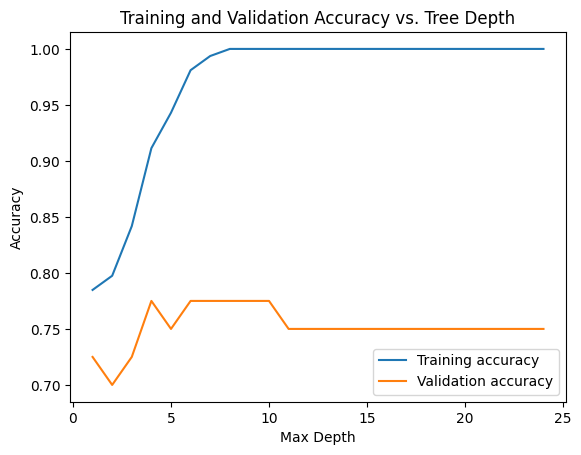

Best Random Forest max_depth=4
train acc=0.9113924050632911
validation acc=0.775
Kept 10904 / 20000 synthetic samples after semantic filtering


In [ ]:
# TUTOR Scheme A
accs_a, precs_a, recs_a, f1s_a = [], [], [], []
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=0)
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Fcats = [0, 2, 5, 6, 8, 10, 12]  # categorical feature indices
Fcont = [i for i in range(X_df.shape[1]) if i not in Fcats]  # continuous features

for fold, (train_idx, test_idx) in enumerate(skf.split(X_df, y_df), 1):
    print(f"\n--- TUTOR Scheme A Fold {fold} ---")

    X_trainval = X_df.iloc[train_idx]
    y_trainval = y_df.iloc[train_idx]
    X_test = X_df.iloc[test_idx]
    y_test = y_df.iloc[test_idx]

    # Split trainval into train and val
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval
    )

    X_tr_arr = X_train.values.astype(np.float32)
    X_val_arr = X_val.values.astype(np.float32)
    X_te_arr = X_test.values.astype(np.float32)

    y_tr = y_train.values.ravel()
    y_te = y_test.values.ravel()
    y_va = y_val.values.ravel()

    # 1) Preprocessing: scale + PCA on continuous features
    scaler = StandardScaler().fit(X_tr_arr[:, Fcont])
    X_tr_s = scaler.transform(X_tr_arr[:, Fcont])
    X_te_s = scaler.transform(X_te_arr[:, Fcont])
    X_val_s = scaler.transform(X_val_arr[:, Fcont])
    pca = PCA(n_components=0.95, whiten=True).fit(X_tr_s)
    X_tr_pca = pca.transform(X_tr_s)
    X_te_pca = pca.transform(X_te_s)
    X_val_pca = pca.transform(X_val_s)

    # 2) Train labeler on real data
    best_max_depth, train_accs, validation_accs = find_best_rf_max_depth(X_tr_pca, y_tr, X_val_pca, y_va)
    rf_best = RandomForestClassifier(n_estimators=350, max_depth=best_max_depth, criterion='gini', random_state=42)
    rf_best.fit(X_tr_pca, y_tr)

    # 3) Generate synthetic data
    X_syn_raw = syn_data_gen_kde(X_train, X_val)
    X_syn_arr = X_syn_raw.astype(np.float32)

    # 4) Filter synthetic data with semantic classifier
    verified_syn = semantic_integrity_classifier(
        X_syn_arr,
        X_tr_arr,
        X_val_arr,
        Fcont,
        Fcats
    )

    # 5) Label and preprocess filtered synthetics
    X_syn_s = scaler.transform(verified_syn[:, Fcont])
    X_syn_pca = pca.transform(X_syn_s)
    y_syn = rf.predict(X_syn_pca)

    # 6) Compute class weights
    cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)
    cw_dict = dict(enumerate(cw))

    # 7) Pretrain on synthetic data
    model = build_model(input_dim=X_tr_pca.shape[1], hidden_units=200)
    model.fit(X_syn_pca, y_syn, epochs=500, batch_size=32, verbose=0)

    # 8) Fine-tune on real data
    history = model.fit(
        X_tr_pca, y_tr,
        validation_split=0.1,
        epochs=1500,
        batch_size=32,
        class_weight=cw_dict,
        callbacks=[reduce_lr, es],
        verbose=0
    )

    # 9) Evaluate on test set
    y_pred = (model.predict(X_te_pca, batch_size=32, verbose=0) > 0.5).astype(int).ravel()
    a = accuracy_score(y_te, y_pred)
    p = precision_score(y_te, y_pred, zero_division=0)
    r = recall_score(y_te, y_pred, zero_division=0)
    f1 = f1_score(y_te, y_pred, zero_division=0)
    print(f"Accuracy: {a:.3f}, Precision: {p:.3f}, Recall: {r:.3f}, F1: {f1:.3f}")

    accs_a.append(a); precs_a.append(p); recs_a.append(r); f1s_a.append(f1)

# Summary
print("\n--- TUTOR Scheme A Cross-Validation Summary ---")
print(f"Accuracy : {np.mean(accs_a):.3f}")
print(f"Precision: {np.mean(precs_a):.3f}")
print(f"Recall   : {np.mean(recs_a):.3f}")
print(f"F1 Score : {np.mean(f1s_a):.3f}")


In [36]:
# TUTOR Scheme B
accs_b, precs_b, recs_b, f1s_b = [], [], [], []
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=0)
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Fcats = [0, 2, 5, 6, 8, 10, 12]
Fcont = [i for i in range(X_df.shape[1]) if i not in Fcats]

for fold, (train_idx, test_idx) in enumerate(skf.split(X_df, y_df), 1):
    print(f"\n--- TUTOR Scheme B Fold {fold} ---")

    # Train/test split
    X_trainval = X_df.iloc[train_idx]
    y_trainval = y_df.iloc[train_idx]
    X_test = X_df.iloc[test_idx]
    y_test = y_df.iloc[test_idx]

    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42
    )

    X_tr_arr = X_train.values.astype(np.float32)
    X_val_arr = X_val.values.astype(np.float32)
    X_te_arr = X_test.values.astype(np.float32)

    y_tr = y_train.values.ravel()
    y_val = y_val.values.ravel()
    y_te = y_test.values.ravel()

    # Scale + PCA
    scaler = StandardScaler().fit(X_tr_arr[:, Fcont])
    X_tr_s = scaler.transform(X_tr_arr[:, Fcont])
    X_val_s = scaler.transform(X_val_arr[:, Fcont])
    X_te_s = scaler.transform(X_te_arr[:, Fcont])
    pca = PCA(n_components=0.95, whiten=True).fit(X_tr_s)
    X_tr_pca = pca.transform(X_tr_s)
    X_val_pca = pca.transform(X_val_s)
    X_te_pca = pca.transform(X_te_s)

    # Random Forest KB
    rf = RandomForestClassifier(n_estimators=350, random_state=42)
    rf.fit(X_tr_pca, y_tr)

    # Synthetic data
    X_syn_raw = syn_data_gen_kde(X_train, X_val)
    verified_syn = semantic_integrity_classifier(X_syn_raw, X_tr_arr, X_val_arr, Fcont, Fcats)
    X_syn_s = scaler.transform(verified_syn[:, Fcont])
    X_syn_pca = pca.transform(X_syn_s)
    y_syn = rf.predict(X_syn_pca)

    # Train individual models
    model_syn = build_model(input_dim=X_tr_pca.shape[1], hidden_units=200)
    model_syn.fit(X_syn_pca, y_syn, epochs=200, batch_size=32, verbose=0)

    model_real = build_model(input_dim=X_tr_pca.shape[1], hidden_units=200)
    model_real.fit(X_tr_pca, y_tr, epochs=200, batch_size=32, verbose=0)

    # Get representations from each
    model_syn(X_tr_pca[:1])
    extractor_syn = Model(inputs=model_syn.input, outputs=model_syn.layers[-2].output)
    extractor_real = Model(inputs=model_real.input, outputs=model_real.layers[-2].output)

    X_tr_syn_out = extractor_syn.predict(X_tr_pca, verbose=0)
    X_tr_real_out = extractor_real.predict(X_tr_pca, verbose=0)

    X_val_syn_out = extractor_syn.predict(X_val_pca, verbose=0)
    X_val_real_out = extractor_real.predict(X_val_pca, verbose=0)

    X_te_syn_out = extractor_syn.predict(X_te_pca, verbose=0)
    X_te_real_out = extractor_real.predict(X_te_pca, verbose=0)

    # Build combined model
    combined_model = build_combined_model(input_dim=X_tr_pca.shape[1], hidden_units=200)
    history = combined_model.fit(
        [X_tr_pca, X_tr_pca], y_tr,
        validation_data=([X_val_pca, X_val_pca], y_val),
        epochs=500,
        batch_size=32,
        verbose=0
    )

    # Evaluate on test set
    y_pred = (combined_model.predict([X_te_pca, X_te_pca], batch_size=32, verbose=0) > 0.5).astype(int).ravel()
    a = accuracy_score(y_te, y_pred)
    p = precision_score(y_te, y_pred, zero_division=0)
    r = recall_score(y_te, y_pred, zero_division=0)
    f1 = f1_score(y_te, y_pred, zero_division=0)
    print(f"Accuracy: {a:.3f}, Precision: {p:.3f}, Recall: {r:.3f}, F1: {f1:.3f}")

    accs_b.append(a); precs_b.append(p); recs_b.append(r); f1s_b.append(f1)

# Summary
print("\n--- TUTOR Scheme B Cross-Validation Summary ---")
print(f"Mean Accuracy: {np.mean(accs_b):.3f}")
print(f"Mean Precision: {np.mean(precs_b):.3f}")
print(f"Mean Recall: {np.mean(recs_b):.3f}")
print(f"Mean F1 Score: {np.mean(f1s_b):.3f}")


--- TUTOR Scheme B Fold 1 ---
Kept 10741 / 20000 synthetic samples after semantic filtering


TypeError: cannot unpack non-iterable Functional object